# IBM Data Science Capstone

Bruno Pellanda

May 2021

![Curitiba](https://github.com/pellanda/Coursera_Capstone/blob/master/Collage_Curitiba.png?raw=true)

## Introduction

Curitiba is one of the biggest city in Brazil. As a resident of this city, I decided to use it in my capstone project.

Curitiba is divided by more than 70 districts, based on that, we can analyze how each district is similar with others and how the square meter price is distribuited over the city.

When we consider all these, we can create a map and information chart where the real estate index is placed on Curitiba and each district is clustered according to the venue similarities provided by foursquare API.

## Data

For this project I will be using data from three diferent locations:

- IPPUC (research and urban planning institute of Curitiba) geographical data (http://ippuc.org.br/geodownloads/geo.htm)
- Web scraping data from square meter price from Curitiba from a national news portal report from 24/11/2020 (https://g1.globo.com/pr/parana/economia/noticia/2020/11/24/metro-quadrado-de-imoveis-de-nove-bairros-de-curitiba-valorizaram-mais-de-10percent-em-12-meses-veja-lista.ghtml)
- Foursquare API to gather information about venues located in my places of interest

## Methodology

The main idea is gather all data from these sources and transform it in Pandas DataFrame to apply all transformations necessary to extract the information we want

## Notebook (Execution)

### Installing necessary packages

In [1]:
#!conda install -c conda-forge geopy --yes

In [2]:
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


### Importing libraries

In [3]:
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

import requests # library to handle requests
from bs4 import BeautifulSoup

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import rcParams

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

### Reading files

In [4]:
df_data_1 = pd.read_csv('https://raw.githubusercontent.com/pellanda/Coursera_Capstone/master/final/DIVISA_DE_BAIRROS2.csv', encoding= 'unicode_escape')
df_data_1.head()

,LONGITUDE,LATITUDE,OBJECTID,CODIGO,TIPO,NOME,FONTE,CD_REGIONA,NM_REGIONA,SHAPE_AREA,SHAPE_LEN
0,-49.279004,-25.456788,20,9,DIVISA DE BAIRROS,ÁGUA VERDE,Decreto Municipal 774 / 1975,7,REGIONAL PORTÃO,4.773046e+06,9760.918367
1,-49.233693,-25.418896,22,18,DIVISA DE BAIRROS,JARDIM SOCIAL,Decreto Municipal 774 / 1975,1,REGIONAL MATRIZ,1.958422e+06,6055.953058
2,-49.269640,-25.506455,23,57,DIVISA DE BAIRROS,XAXIM,Decreto Municipal 774 / 1975,2,REGIONAL BOQUEIRÃO,9.085391e+06,13783.592828
3,-49.230947,-25.457777,5,22,DIVISA DE BAIRROS,JARDIM DAS AMÉRICAS,Decreto Municipal 774 / 1975,3,REGIONAL CAJURU,3.859034e+06,8818.503767
4,-49.273250,-25.469386,9,26,DIVISA DE BAIRROS,GUAÍRA,Decreto Municipal 774 / 1975,7,REGIONAL PORTÃO,2.311397e+06,6351.958996


In [5]:
curitiba = df_data_1.loc[:, ['NOME', 'LATITUDE', 'LONGITUDE']]

curitiba.rename({'NOME': 'BOROUGH'}, axis = 1, inplace = True)
curitiba.head()

,BOROUGH,LATITUDE,LONGITUDE
0,ÁGUA VERDE,-25.456788,-49.279004
1,JARDIM SOCIAL,-25.418896,-49.233693
2,XAXIM,-25.506455,-49.269640
3,JARDIM DAS AMÉRICAS,-25.457777,-49.230947
4,GUAÍRA,-25.469386,-49.273250


Gathering info from Curitiba:

In [6]:
address = 'Curitiba, Parana, Brazil'

geolocator = Nominatim(user_agent="curitiba-teste")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Curitiba are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Curitiba are -25.4295963, -49.2712724.


Map from Curitiba with centralized points identifing each borough:

In [7]:
map_curitiba = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to map
for lat, lng, borough in zip(curitiba['LATITUDE'], curitiba['LONGITUDE'], curitiba['BOROUGH']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_curitiba)  
    
map_curitiba

### Webscraping data from news portal:

In [8]:
source = requests.get('https://g1.globo.com/pr/parana/economia/noticia/2020/11/24/metro-quadrado-de-imoveis-de-nove-bairros-de-curitiba-valorizaram-mais-de-10percent-em-12-meses-veja-lista.ghtml').text
soup=BeautifulSoup(source,'xml')

table_contents=[]
table=soup.find('table')

table_rows=table.find_all('tr')[1:] # remove header

In [9]:
borough_price = pd.DataFrame(columns=["BOROUGH", "VALUE", "VARIATION 12 MONTH"])

for i,row in enumerate(table_rows):
    cells=row.find_all('td')
    borough = cells[0].text.strip().upper()
    value = cells[1].text.strip()
    variation = cells[2].text.strip()
    
    borough_price = borough_price.append({"BOROUGH":borough, "VALUE":value, "VARIATION 12 MONTH":variation}, ignore_index=True)
    

#fixing borough names to match with data read before
borough_price['BOROUGH']=borough_price['BOROUGH'].replace({'AHU':'AHÚ',
                                                           'ALTO DA GLORIA':'ALTO DA GLÓRIA',
                                                           'REBOUAS':'REBOUÇAS',
                                                           'CIC':'CIDADE INDUSTRIAL DE CURITIBA',
                                                           'SITIO CERCADO':'SÍTIO CERCADO'})    
    
borough_price.head()    

,BOROUGH,VALUE,VARIATION 12 MONTH
0,BATEL,9.611,"12,6%"
1,CAMPINA DO SIQUEIRA,8.401,"6,7%"
2,JUVEVÊ,8.379,"11,6%"
3,AHÚ,8.320,"7,1%"
4,MERCÊS,8.308,"7,0%"


Creating merged DataFrame:

In [10]:
df = curitiba.merge(borough_price, how='left', on='BOROUGH')

### Foursquare API data

In [43]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [12]:
curitiba_data = df

borough_latitude = curitiba_data.loc[0, 'LATITUDE'] # neighborhood latitude value
borough_longitude = curitiba_data.loc[0, 'LONGITUDE'] # neighborhood longitude value

borough_name = curitiba_data.loc[0, 'BOROUGH'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of ÁGUA VERDE are -25.4567876976144, -49.279004239562205.


First, let's create the GET request URL. Name your URL url. I design the limit as 100 venue and the radius 1500 meter for each borough

In [13]:
LIMIT = 100
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)

In [14]:
results = requests.get(url).json()

From the Foursquare lab, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tempeadori Restaurante,Brazilian Restaurant,-25.456788,-49.278547
1,Marco Silva Academia de Tênis,Tennis Court,-25.457070,-49.275973
2,Cervejaria Curitibana,Beer Store,-25.455146,-49.277018
3,Bolo Brasil,Dessert Shop,-25.456279,-49.278017
4,Restaurante Ibérico,Spanish Restaurant,-25.453235,-49.276991


And how many venues were returned by Foursquare?

In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Let's create a function to get all the boroughs in Curitiba

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can run the above function on each borough and create a new dataframe called curitiba_venues

In [19]:
curitiba_venues = getNearbyVenues(names=curitiba_data['BOROUGH'],
                                   latitudes=curitiba_data['LATITUDE'],
                                   longitudes=curitiba_data['LONGITUDE']
                                  )

How many venues from each borough?

In [20]:
summary = curitiba_venues.groupby('Borough').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Borough Latitude', 'Borough Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary

,Borough,Count
0,CAXIMBA,1
1,UMBARÁ,4
2,LAMENHA PEQUENA,4
3,RIVIERA,4
4,TATUQUARA,4
...,...,...
70,JUVEVÊ,100
71,MERCÊS,100
72,NOVO MUNDO,100
73,PRADO VELHO,100


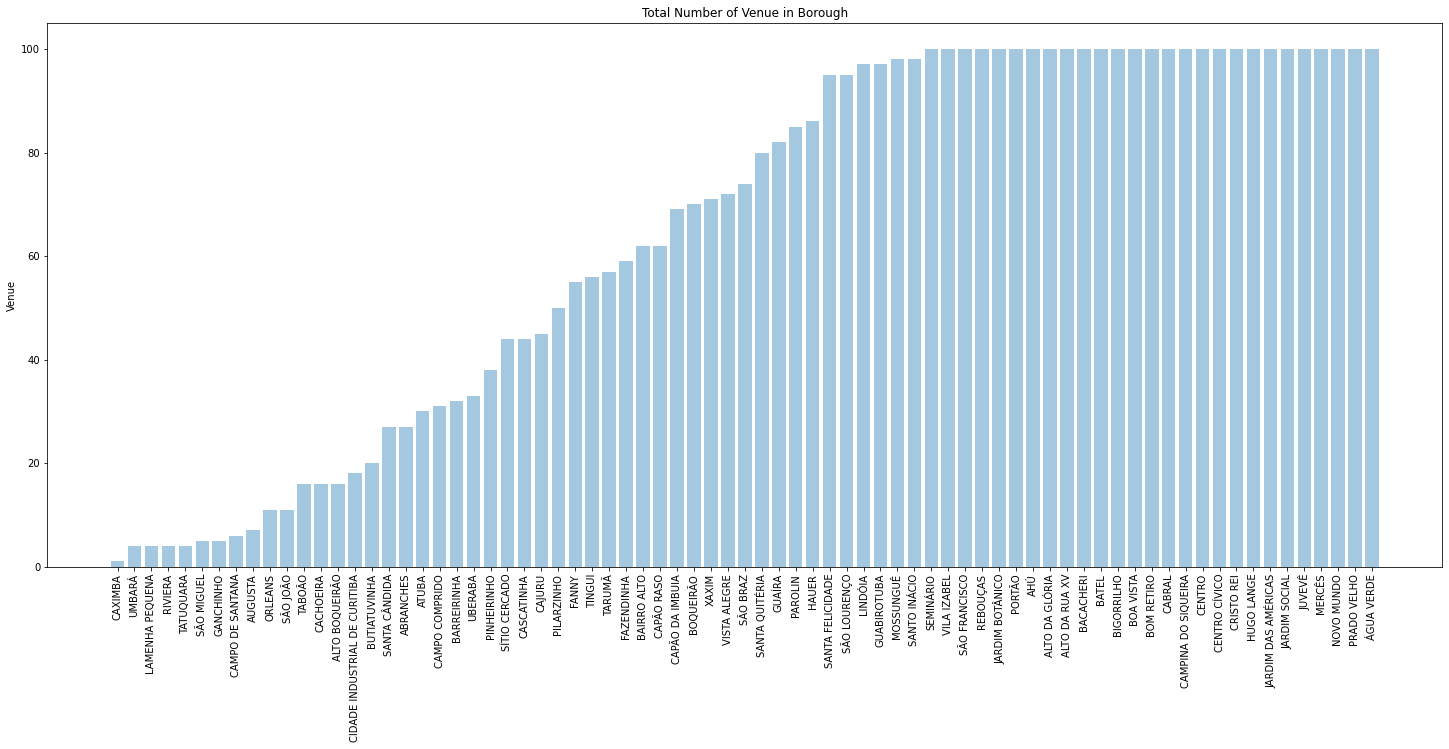

In [21]:
rcParams['figure.figsize'] = 25, 10

objects = summary.Borough
y_pos = np.arange(len(objects))
performance = summary.Count


plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

### K-means data preparation

In [22]:
print('There are {} uniques categories.'.format(len(curitiba_venues['Venue Category'].unique())))

There are 289 uniques categories.


In [23]:
# one hot encoding
curitiba_onehot = pd.get_dummies(curitiba_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
curitiba_onehot['Borough'] = curitiba_venues['Borough'] 

# move neighborhood column to the first column
list_column = curitiba_onehot.columns.tolist()
number_column = int(list_column.index('Borough'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
curitiba_onehot = curitiba_onehot[list_column]

curitiba_onehot.head()

,Borough,Acai House,Accessories Store,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ÁGUA VERDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ÁGUA VERDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ÁGUA VERDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ÁGUA VERDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ÁGUA VERDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
curitiba_grouped = curitiba_onehot.groupby('Borough').sum().reset_index()
curitiba_grouped.head()

,Borough,Acai House,Accessories Store,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ABRANCHES,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AHÚ,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,0,1
2,ALTO BOQUEIRÃO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ALTO DA GLÓRIA,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
4,ALTO DA RUA XV,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

After grouping by and counting, let´s get only TOP 10 venues from each borough to use for clustering

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = curitiba_grouped['Borough']

for ind in np.arange(curitiba_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(curitiba_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABRANCHES,Bakery,Grocery Store,Pizza Place,Juice Bar,Soccer Field,Motorcycle Shop,Brazilian Restaurant,Snack Place,Bar,Ice Cream Shop
1,AHÚ,Pizza Place,Gym / Fitness Center,Coffee Shop,Bakery,Dessert Shop,Pet Store,Italian Restaurant,Steakhouse,Restaurant,Bar
2,ALTO BOQUEIRÃO,Bakery,Pizza Place,Train Station,Soccer Field,Stadium,Supermarket,Market,Grocery Store,Pastelaria,Gym
3,ALTO DA GLÓRIA,Italian Restaurant,Pharmacy,Middle Eastern Restaurant,Bar,Food Truck,Restaurant,Theater,Coffee Shop,Brazilian Restaurant,Dessert Shop
4,ALTO DA RUA XV,Dessert Shop,Restaurant,Italian Restaurant,Coffee Shop,Bar,Pizza Place,Gym / Fitness Center,Burger Joint,Health Food Store,Middle Eastern Restaurant


Let´s use the Elbow Method to determine the best K

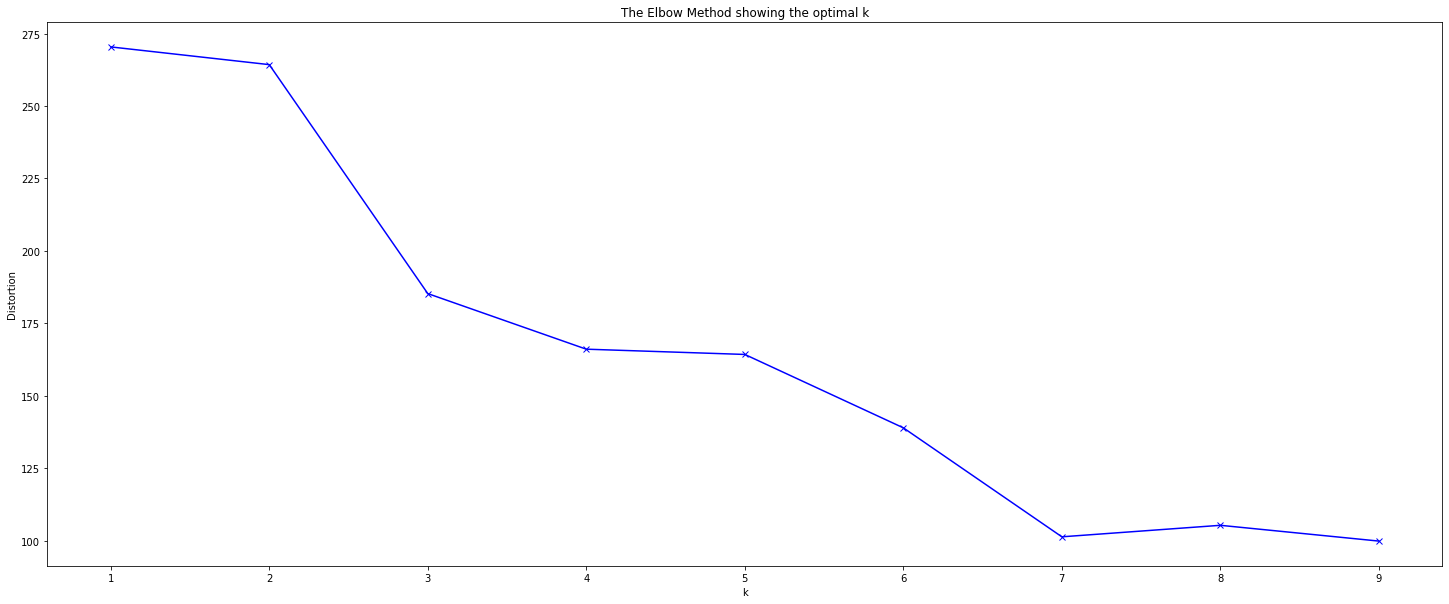

In [27]:
curitiba_grouped_clustering = curitiba_grouped.drop('Borough', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(curitiba_grouped_clustering)
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(curitiba_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / curitiba_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As we can see, we could use 4 or 6 clusters, and to learning purpose only I will be picking k = 4

In [28]:
# set number of clusters
kclusters = 4

curitiba_grouped_clustering = curitiba_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(curitiba_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([2, 0, 2, 3, 0, 2, 2, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 2, 2, 0, 2, 2,
       1, 1, 2, 2, 3, 3, 2, 0, 2, 2, 2, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0,
       0, 0, 2, 1, 2, 2, 0, 1, 3, 2, 2, 0, 1, 1, 0, 1, 3, 2, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 0, 1, 1, 0], dtype=int32)

If any borough has no info in foursquare we remove it from our dataframe

In [29]:
common_bourough = list(set(curitiba_data['BOROUGH']) - set(boroughs_venues_sorted['Borough']))
common_bourough

[]

In [30]:
curitiba_merged = curitiba_data.copy()

curitiba_merged.rename({'BOROUGH': 'Borough'}, axis = 1, inplace = True)
curitiba_merged = curitiba_merged[~curitiba_merged.Borough.isin(common_bourough)]


# add clustering labels
curitiba_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
curitiba_merged = curitiba_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

curitiba_merged.head()

,Borough,LATITUDE,LONGITUDE,VALUE,VARIATION 12 MONTH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ÁGUA VERDE,-25.456788,-49.279004,7.110,"4,5%",2,Gym / Fitness Center,Bakery,Bar,Brazilian Restaurant,Pizza Place,Burger Joint,Italian Restaurant,Dessert Shop,Farmers Market,Japanese Restaurant
1,JARDIM SOCIAL,-25.418896,-49.233693,NaN,NaN,0,Gym / Fitness Center,Italian Restaurant,Bakery,Pizza Place,Dessert Shop,Burger Joint,Pet Store,Pharmacy,Restaurant,Bar
2,XAXIM,-25.506455,-49.269640,4.002,"4,1%",2,Pizza Place,Fast Food Restaurant,Bakery,Burger Joint,Snack Place,Gym / Fitness Center,Grocery Store,Soccer Field,Food Truck,Supermarket
3,JARDIM DAS AMÉRICAS,-25.457777,-49.230947,6.865,"4,5%",3,Brazilian Restaurant,Gym / Fitness Center,Bakery,Supermarket,Café,Pizza Place,Burger Joint,Gym,Sandwich Place,Bar
4,GUAÍRA,-25.469386,-49.273250,5.170,"9,1%",0,Bakery,Pizza Place,Bar,Brazilian Restaurant,Gym,Gym / Fitness Center,Hot Dog Joint,Beer Bar,Theme Park,Market


Let´s see the most commom venue in each borough to give a name for our clusters

In [31]:
count_venue = curitiba_merged
count_venue = count_venue.drop(['Borough','VALUE', 'LATITUDE', 'LONGITUDE'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Bakery,Bar,Brazilian Restaurant,Buffet,Café,Church,Coffee Shop,Cosmetics Shop,Department Store,Dessert Shop,...,Monument / Landmark,Park,Pet Store,Pharmacy,Pizza Place,Restaurant,Snack Place,Soccer Field,Steakhouse,Theater
0,9,1,1,0,0,0,0,1,0,0,...,0,0,1,0,2,0,0,1,0,0
1,2,1,0,0,0,0,1,1,0,0,...,1,0,0,1,4,1,1,1,0,0
2,4,1,2,1,1,1,0,1,0,1,...,0,1,0,0,10,1,0,1,0,1
3,0,0,2,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


Text(0, 0.5, 'Clusters')

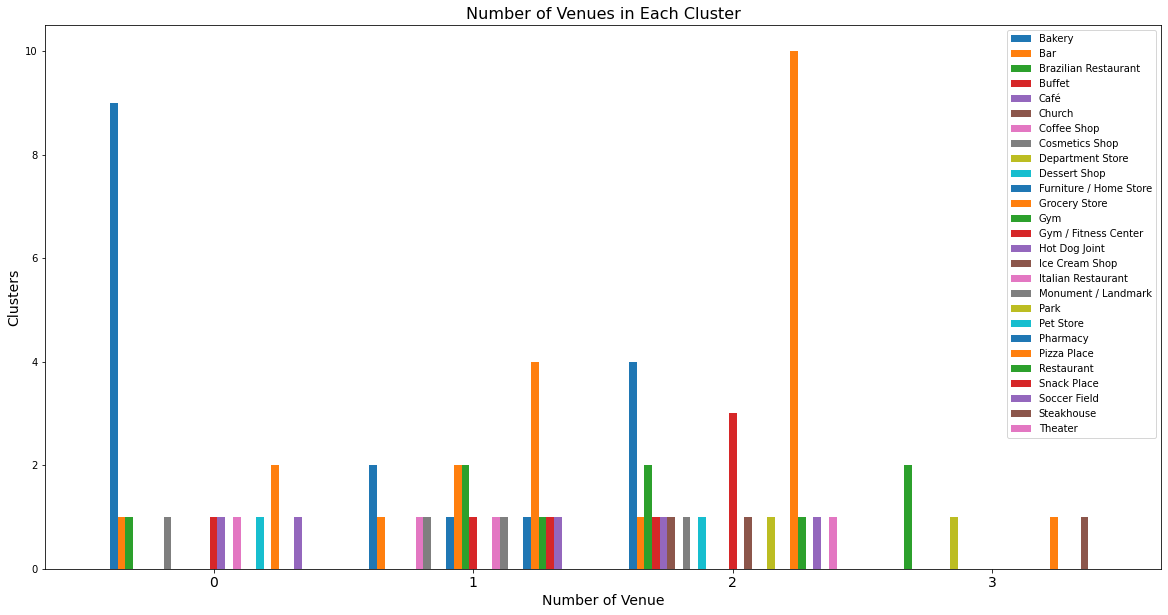

In [32]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,10),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 10)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

When we examine above graph we can label each cluster as follows:

- Cluster 0 : "Bakery Venues" 
- Cluster 1 : "Multiple Venues" 
- Cluster 2 : "Gym & Pizza Venues" 
- Cluster 3 : "Brazilian Restaurant Venues"

We can now assign those new labels to existing label of clusters:

In [33]:
Cluster_labels = {'Clusters': [0,1,2,3], 'Labels': ["Bakery Venues", "Multiple Venues", "Gym & Pizza Venues","Brazilian Restaurant Venues"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Bakery Venues
1,1,Multiple Venues
2,2,Gym & Pizza Venues
3,3,Brazilian Restaurant Venues


Consolidating info from foursquare with real state values

In [34]:
data_process = curitiba_merged.loc[:, ['Borough', 'VALUE', 'Cluster Labels']]
data_process['VALUE'] = data_process['VALUE'].str.replace('.', '').fillna(0).astype(int)

data_process.head()

,Borough,VALUE,Cluster Labels
0,ÁGUA VERDE,7110,2
1,JARDIM SOCIAL,0,0
2,XAXIM,4002,2
3,JARDIM DAS AMÉRICAS,6865,3
4,GUAÍRA,5170,0


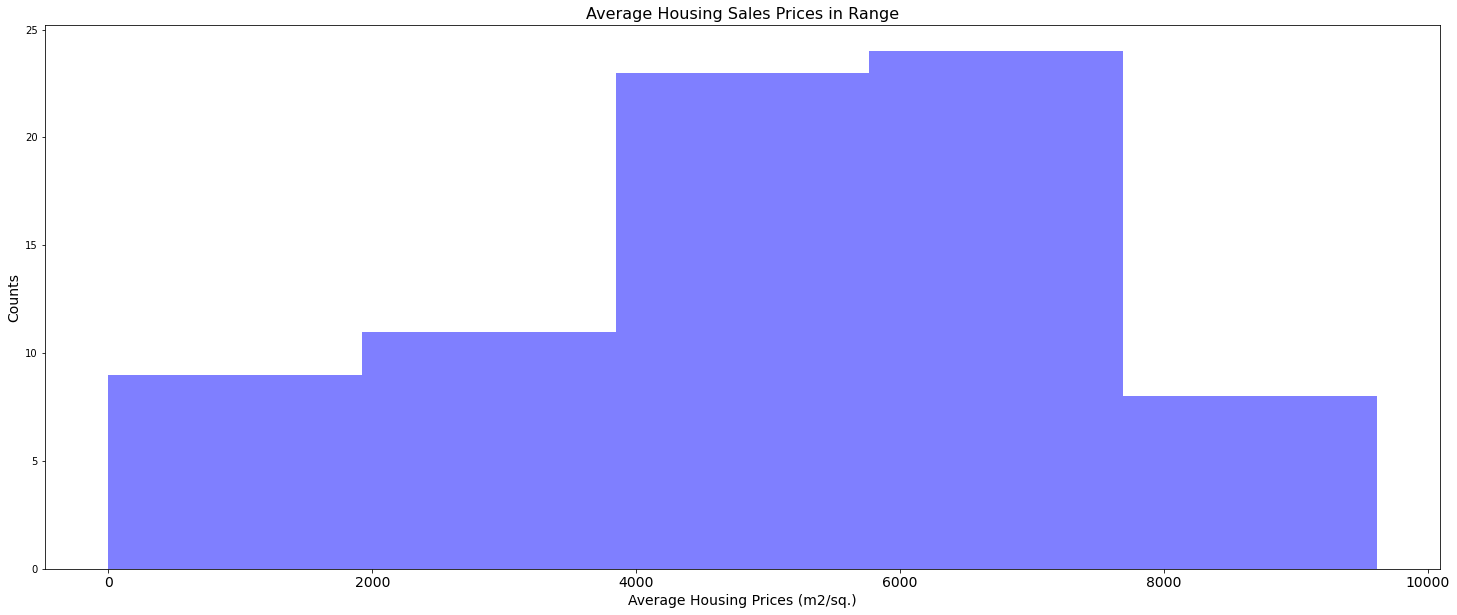

In [35]:
num_bins = 5
n, bins, patches = plt.hist(data_process['VALUE'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Average Housing Sales Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Housing Prices (m2/sq.)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

As we did with clusters, we are doing with house prices to visualize better the info

In [36]:
level = []
for i in range(0,len(data_process)):
    if (data_process['VALUE'][i] == 0):
        level.append("Unknown")
    elif (data_process['VALUE'][i] > 0 and data_process['VALUE'][i] < 2000):
        level.append("Low Level HSP")
    elif (data_process['VALUE'][i] >= 2000 and data_process['VALUE'][i] < 4000):
        level.append("Mid-1 Level HSP")
    elif (data_process['VALUE'][i] >= 4000 and data_process['VALUE'][i] < 6000):
        level.append("Mid-2 Level HSP")
    elif (data_process['VALUE'][i] >= 6000 and data_process['VALUE'][i] < 8000):
        level.append("High-1 Level HSP")
    else:
        level.append("High-2 Level HSP")   

data_process['Level_labels'] = level
data_process.head()

,Borough,VALUE,Cluster Labels,Level_labels
0,ÁGUA VERDE,7110,2,High-1 Level HSP
1,JARDIM SOCIAL,0,0,Unknown
2,XAXIM,4002,2,Mid-2 Level HSP
3,JARDIM DAS AMÉRICAS,6865,3,High-1 Level HSP
4,GUAÍRA,5170,0,Mid-2 Level HSP


One of my aim was also show the number of top 3 venues information for each borough on the map. Thus, I grouped each borough by the number of top 3 venues and I combined those informations in Join column.

In [37]:
top3 = curitiba_venues.groupby(['Borough','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Borough','Counts'],ascending=False).groupby('Borough').head(3).reset_index(drop=True)

top3['Join'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Borough'])['Join'].apply(", ".join).reset_index()

top3.head()

,Borough,Join
0,ABRANCHES,"6 Bakery, 3 Grocery Store, 3 Pizza Place"
1,AHÚ,"7 Pizza Place, 5 Coffee Shop, 5 Gym / Fitness ..."
2,ALTO BOQUEIRÃO,"2 Bakery, 1 Diner, 1 Grocery Store"
3,ALTO DA GLÓRIA,"5 Italian Restaurant, 4 Bar, 4 Middle Eastern ..."
4,ALTO DA RUA XV,"5 Dessert Shop, 5 Italian Restaurant, 5 Restau..."


In [38]:
result = pd.merge(curitiba_merged, 
                    top3[['Borough', 'Join']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Borough', 'Level_labels']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(3)

,Borough,LATITUDE,LONGITUDE,VALUE,VARIATION 12 MONTH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Join,Labels,Level_labels
0,ÁGUA VERDE,-25.456788,-49.279004,7.110,"4,5%",2,Gym / Fitness Center,Bakery,Bar,Brazilian Restaurant,Pizza Place,Burger Joint,Italian Restaurant,Dessert Shop,Farmers Market,Japanese Restaurant,"8 Gym / Fitness Center, 6 Bakery, 5 Bar",Gym & Pizza Venues,High-1 Level HSP
1,JARDIM SOCIAL,-25.418896,-49.233693,NaN,NaN,0,Gym / Fitness Center,Italian Restaurant,Bakery,Pizza Place,Dessert Shop,Burger Joint,Pet Store,Pharmacy,Restaurant,Bar,"7 Gym / Fitness Center, 7 Italian Restaurant, ...",Bakery Venues,Unknown
2,XAXIM,-25.506455,-49.269640,4.002,"4,1%",2,Pizza Place,Fast Food Restaurant,Bakery,Burger Joint,Snack Place,Gym / Fitness Center,Grocery Store,Soccer Field,Food Truck,Supermarket,"7 Pizza Place, 5 Bakery, 5 Fast Food Restaurant",Gym & Pizza Venues,Mid-2 Level HSP


KNN Result

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['LATITUDE'], result['LONGITUDE'], result['Borough'], result['Labels'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### Now let put all together (prices and clusters in one map)

In [40]:
!wget --quiet https://raw.githubusercontent.com/pellanda/Coursera_Capstone/master/bairros.geo.json -O curitiba_geo.json
    
curitiba_geo = r'curitiba_geo.json'

#Curitiba
latitude = -25.4295963
longitude = -49.2712724

# display Curitiba
curitiba_map = folium.Map(location=[latitude, longitude], zoom_start=10)#

In [41]:
ctba_data = result.loc[:, ['Borough', 'VALUE', 'LATITUDE', 'LONGITUDE']]
ctba_data['VALUE'] = ctba_data['VALUE'].str.replace('.', '').fillna(0).astype(int)

In [42]:
curitiba_map.choropleth(
    geo_data=curitiba_geo,
    data=ctba_data,
    columns=['Borough','VALUE'],
    key_on='feature.properties.nome',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='House Sales Price in Curitiba',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['LATITUDE'], result['LONGITUDE'], result['Borough'], result['Labels'], result['Join'], 
                                                               result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker([lat, lon], radius=7, popup=label, color= rainbow[cluster_number-1], fill=True, fill_color= rainbow[cluster_number-1], fill_opacity=1).add_to(curitiba_map)

    
curitiba_map

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Discussion

I used the Kmeans algorithm as part of this clustering study. When I tested the Elbow method, I set the optimum k value to 4 but 6 clusters could be possible too, maybe worth try it another time.

Some borough have 20 or less venues, because foursquare is not so popular here or because the size of each borough, I´ve started with 750 meter radius then I doubled it. Maybe choose the radius based on the size of each borough could give us more information for this 'less popular' boroughs.

## Conclusion

As we can see, Curitiba´s downtown is the most expensive location in the city, as far we go, lower the price is. But from clusters we can see that it is very well distributed. There are places all over the city to find a pizza to eat or a brazillian restaurant!